<a href="https://colab.research.google.com/github/vishalrk1/Vehicle-Classification-using-HOG-and-KNN/blob/main/Car_Detection_HOG_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing Required Libraries to run code
import glob
import os
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

# Loading Dataset

* [Dataset Link](https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set)

In [5]:
!wget https://github.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/blob/master/vehicles.zip?raw=true

--2022-04-13 07:49:05--  https://github.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/blob/master/vehicles.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/raw/master/vehicles.zip [following]
--2022-04-13 07:49:05--  https://github.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/raw/master/vehicles.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/master/vehicles.zip [following]
--2022-04-13 07:49:05--  https://raw.githubusercontent.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/master/vehicles.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.1

In [6]:
!wget https://github.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/blob/master/non-vehicles.zip?raw=true

--2022-04-13 07:49:07--  https://github.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/blob/master/non-vehicles.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/raw/master/non-vehicles.zip [following]
--2022-04-13 07:49:07--  https://github.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/raw/master/non-vehicles.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/master/non-vehicles.zip [following]
--2022-04-13 07:49:07--  https://raw.githubusercontent.com/harveenchadha/Udacity-CarND-Vehicle-Detection-and-Tracking/master/non-vehicles.zip
Resolving raw.githubusercontent.com (raw.githubuserc

In [7]:
import zipfile
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

unzip_data('/content/vehicles.zip?raw=true')
unzip_data('/content/non-vehicles.zip?raw=true')

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
car_img_path = glob.glob('/content/vehicles/*/*.png')
nocar_img_path = glob.glob('/content/non-vehicles/*/*.png')

In [10]:
def import_images(path_list, img_list):
  for path in tqdm(path_list):
    img_path = path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_list.append(img)
  return img_list

In [11]:
car_images = []
nocar_images = []

In [12]:
print("Loding Car images")
car_images = import_images(car_img_path, car_images)

print("\nLoading Non Car images")
nocar_images = import_images(nocar_img_path, nocar_images)

Loding Car images


  0%|          | 0/8792 [00:00<?, ?it/s]


Loading Non Car images


  0%|          | 0/8968 [00:00<?, ?it/s]

In [13]:
n_car_images = len(car_images)
n_non_car_images = len(nocar_images)
img_shape = car_images[0].shape
print('No. of car images: ', n_car_images)
print('No of non-car images: ', n_non_car_images)
print('Image shape: ', img_shape)

No. of car images:  8792
No of non-car images:  8968
Image shape:  (64, 64, 3)


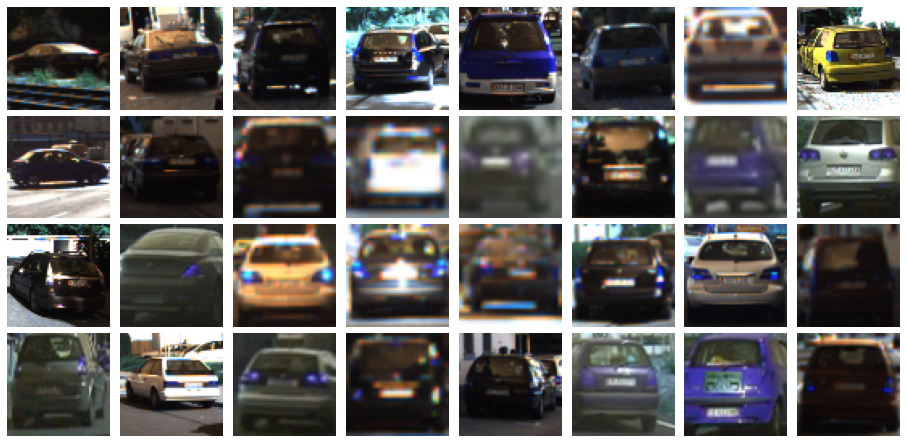

In [14]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = car_images[np.random.randint(0,n_car_images)]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
    
plt.savefig('car_samples.png')

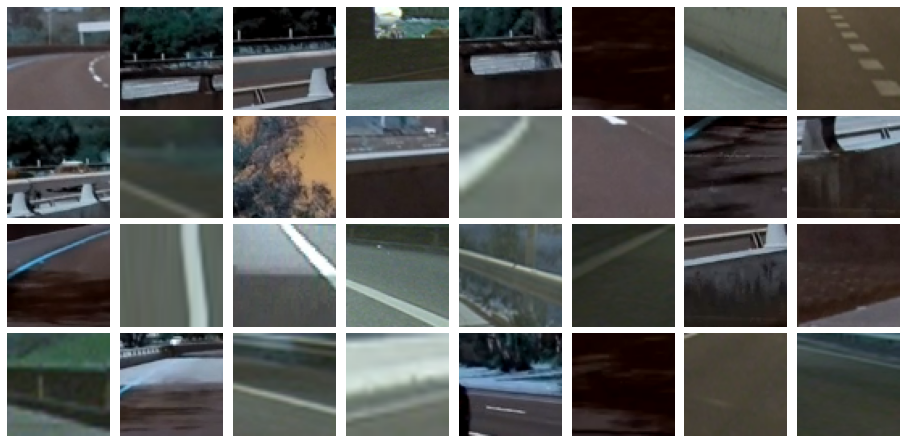

In [15]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = nocar_images[np.random.randint(0,n_non_car_images)]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
    
plt.savefig('nocar_samples.png')

# Feature Extraction using HOG

- Histogram of Oriented gradients

In [16]:
def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
  if(visualise==True):
    hog_features, hog_image = hog(image, orientations=orient,
                      pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                      cells_per_block=(cellsPerBlock, cellsPerBlock), 
                      visualize=True, feature_vector=feature_vector_flag)
    return hog_features, hog_image
  else:
    hog_features = hog(image, orientations=orient,
                      pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                      cells_per_block=(cellsPerBlock, cellsPerBlock), 
                      visualize=False, feature_vector=feature_vector_flag)
    return hog_features

Feature Vector Length Returned is  324
No of features that can be extracted from image  4096


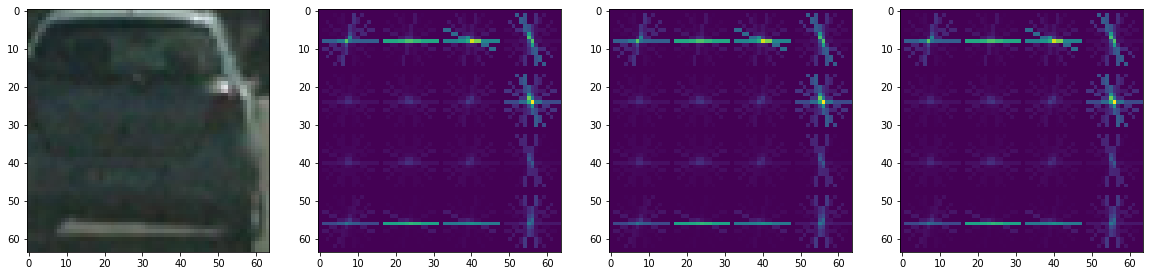

In [17]:
#testing HOG on test images

image= car_images[1]
image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

image_channel_0=image[:,:,0]
image_channel_1=image[:,:,0]
image_channel_2=image[:,:,0]

feature_0,hog_img_0 = GetFeaturesFromHog(image_channel_0,9,2,16,visualise=True,feature_vector_flag=True)
feature_1,hog_img_1 = GetFeaturesFromHog(image_channel_1,9,2,16,visualise=True,feature_vector_flag=True)
feature_2,hog_img_2 = GetFeaturesFromHog(image_channel_2,9,2,16,visualise=True,feature_vector_flag=True)

f, axes= plt.subplots(1,4,figsize=(20,10))
axes[0].imshow(car_images[1])
axes[1].imshow(hog_img_0)
axes[2].imshow(hog_img_1)
axes[3].imshow(hog_img_2)


print("Feature Vector Length Returned is ",len(feature_0))
print("No of features that can be extracted from image ",len(hog_img_0.ravel()))

In [18]:
# Method to extract the features based on the choices as available in step 2

def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
  featureList=[]
  imageList=[]

  for image in images:
    if(convertColorspace==True):
        image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
    local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
    local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
    x=np.hstack((local_features_1,local_features_2,local_features_3))
    featureList.append(x)

  return featureList

In [39]:
orientations=10
cellsPerBlock=2
pixelsPerBlock=8
convertColorSpace=True

vehicleFeatures= ExtractFeatures(car_images,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)

nonVehicleFeatures= ExtractFeatures(nocar_images,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)

In [40]:
featuresList= np.vstack([vehicleFeatures, nonVehicleFeatures])
print("Shape of features list is ", featuresList.shape)

labelList= np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
print("Shape of label list is ", labelList.shape)

Shape of features list is  (17760, 5880)
Shape of label list is  (17760,)


# Preparing data for KNNClassifier

## Spliting Data into train test datasets

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)

## Normalizing Datasets

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN Classification

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
knn = KNeighborsClassifier(n_neighbors=4,  n_jobs=-1)
knn.fit(X_train, y_train)
print(f'Model score: {knn.score(X_test, y_test)}')

Model score: 0.9935247747747747


# Model Evaluation

In [45]:
from sklearn.metrics import classification_report

In [47]:
pred_1 = knn.predict(X_test[0].reshape(1, -1))

pred_1, y_test[0]

(array([1.]), 1.0)

In [68]:
import pickle 

# Its important to use binary mode 
knnPickle = open('knnpickle_file.pkl', 'wb') 

# source, destination 
pickle.dump(knn, knnPickle)  

In [69]:
# load the model from disk
loaded_model = pickle.load(open('/content/knnpickle_file', 'rb'))

In [70]:
pred = loaded_model.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1801
         1.0       1.00      0.99      0.99      1751

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



# Detecting Vechile with sliding window method

In [50]:
# function to draw sliding Windows

import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
  # Make a copy of the image
  imcopy = np.copy(img)
  # Iterate through the bounding boxes
    
  for bbox in bboxes:
    r=random.randint(0,255)
    g=random.randint(0,255)
    b=random.randint(0,255)
    color=(r, g, b)
    # Draw a rectangle given bbox coordinates
    cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
  # Return the image copy with boxes drawn
  return imcopy

In [51]:
# function to find the windows on which we are going to run the classifier

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
   
  if x_start_stop[0] == None:
    x_start_stop[0]=0
  if x_start_stop[1] == None:
    x_start_stop[1]=img.shape[1]
  if y_start_stop[0] ==  None:
    y_start_stop[0]= 0
  if y_start_stop[1] ==  None:
    y_start_stop[1]=img.shape[0]
    
    
  window_list = []
  image_width_x= x_start_stop[1] - x_start_stop[0]
  image_width_y= y_start_stop[1] - y_start_stop[0]
     
  windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
  windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
  modified_window_size= xy_window
  for i in range(0,windows_y):
    y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
    for j in range(0,windows_x):
      x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
      x1 = np.int( x_start +  modified_window_size[0])
      y1= np.int( y_start + modified_window_size[1])
      window_list.append(((x_start,y_start),(x1,y1)))
  return window_list
    

In [53]:
# function that returns the refined Windows
# From Refined Windows we mean that the windows where the classifier predicts the output to be a car

def DrawCars(image,windows, converColorspace=False):
  refinedWindows=[]
  for window in windows:
    start= window[0]
    end= window[1]
    clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
    if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
      clippedImage=cv2.resize(clippedImage, (64,64))
      f1=ExtractFeatures([clippedImage], 10 , 2 , 8,converColorspace)
      predictedOutput=knn.predict([f1[0]])
      # print(predictedOutput)
      if(predictedOutput==1):
        refinedWindows.append(window)
        
  return refinedWindows

In [54]:
# trying out SubSampling using HOG but not able to go through as feature size is not the same.

def DrawCarsOptimised(image, image1, image2,windows, converColorspace=False):
  refinedWindows=[]
  for window in windows:
        
    start= window[0]
    end= window[1]
    clippedImage=image[start[1]:end[1], start[0]:end[0]]
    clippedImage1=image1[start[1]:end[1], start[0]:end[0]]
    clippedImage2=image2[start[1]:end[1], start[0]:end[0]]
        
    if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
      clippedImage=cv2.resize(clippedImage, (64,64)).ravel()
      clippedImage1=cv2.resize(clippedImage1, (64,64)).ravel()
      clippedImage2=cv2.resize(clippedImage2, (64,64)).ravel()
            
      #f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
      f1= np.hstack((clippedImage,clippedImage1,clippedImage2))
      f1=scaler.transform(f1.reshape(1,-1))   
      print(f1.shape)
      predictedOutput=knn.predict([f1[0]])
      if(predictedOutput==1):
        refinedWindows.append(window)
        
  return refinedWindows

In [60]:
#testing our functions of slide_window and draw window. Defining here dummy windows

image = mpimg.imread('/content/test3.jpg')

windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,464], 
                    xy_window=(64,64), xy_overlap=(0.15, 0.15))
windows4 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,480], 
                    xy_window=(80,80), xy_overlap=(0.2, 0.2))
# windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,612], 
#                     xy_window=(96,96), xy_overlap=(0.3, 0.3))
# windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,660], 
#                     xy_window=(128,128), xy_overlap=(0.5, 0.5))


windows = windows1 + windows4 #+  windows3 + windows4
print("Total No of windows are ",len(windows))
refinedWindows=DrawCars(image,windows, True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

Total No of windows are  203


In [61]:
len(windows), len(refinedWindows)

(203, 3)

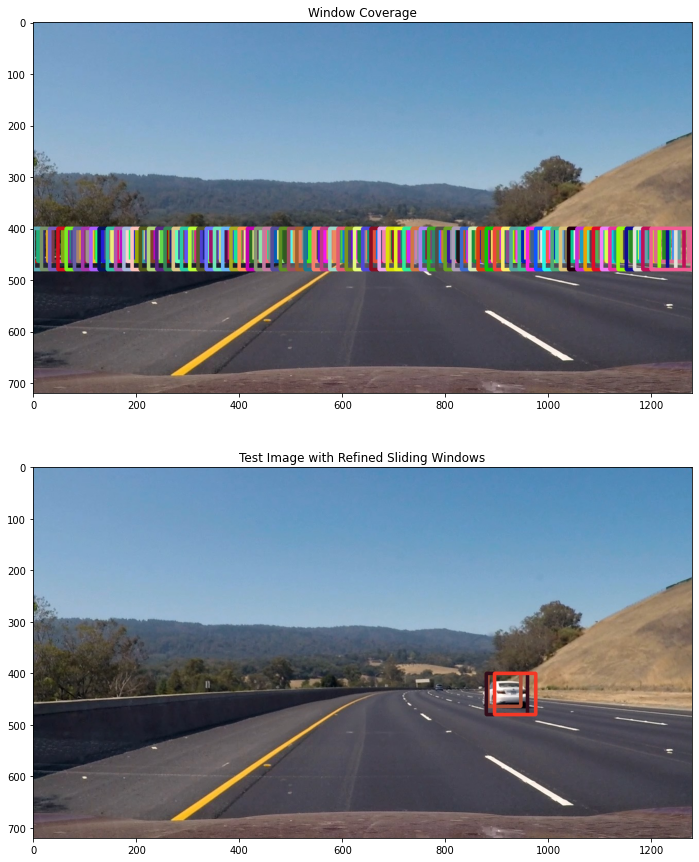

In [62]:
f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)

# Applying HeatMap

In [63]:
# function to increase the pixel by one inside each box

def add_heat(heatmap, bbox_list):
  # Iterate through list of bboxes
  for box in bbox_list:
    # Add += 1 for all pixels inside each bbox
    # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

  # Return updated heatmap
  return heatmap 

In [64]:
# applying a threshold value to the image to filter out low pixel cells

def apply_threshold(heatmap, threshold):
  # Zero out pixels below the threshold
  heatmap[heatmap <= threshold] = 0
  # Return thresholded map
  return heatmap

In [65]:
# find pixels with each car number and draw the final bounding boxes

from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
  # Iterate through all detected cars
  for car_number in range(1, labels[1]+1):
    # Find pixels with each car_number label value
    nonzero = (labels[0] == car_number).nonzero()
    # Identify x and y values of those pixels
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Define a bounding box based on min/max x and y
    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    # Draw the box on the image
    cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
  # Return the image
  return img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


 Number of Cars found -  1


Text(0.5, 1.0, 'Final Image after applying Heat Map')

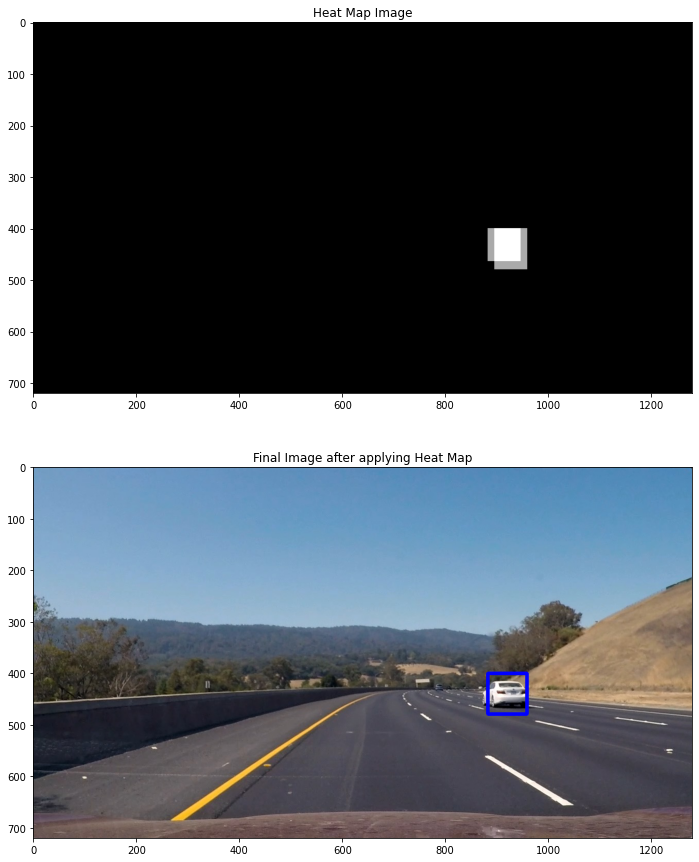

In [67]:
#testing our heat function

heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

heat_image=heatmap

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(" Number of Cars found - ",labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes= plt.subplots(2,1, figsize=(30,15))
axes[0].imshow(heat_image,cmap='gray')
axes[0].set_title("Heat Map Image")
axes[1].imshow(draw_img)
axes[1].set_title("Final Image after applying Heat Map")